In [2]:
import os
import pynwb
import numpy as np
import datajoint as dj
import matplotlib.pyplot as plt

import spyglass.common as sgc
import spyglass.position.v1 as sgp
import spyglass.linearization.v1 as sgpl

from spyglass.position import PositionOutput
import pandas as pd

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

[2024-01-02 13:11:55,852][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-01-02 13:11:55,938][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


## Make the Track graphs

In [36]:
sgc.Session & "nwb_file_name LIKE 'Bilbo%'"

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
Bilbo20230722_.nwb,Bilbo,"University of California, San Francisco",Loren Frank Lab,1,Medial Septal stimulation,2023-07-22 12:45:56,1970-01-01 00:00:00,Medial Septal rhythmic and theta phase specific stimulation
Bilbo20230724_.nwb,Bilbo,"University of California, San Francisco",Loren Frank Lab,2,Medial Septal stimulation,2023-07-24 09:18:03,1970-01-01 00:00:00,Medial Septal rhythmic and theta phase specific stimulation
Bilbo20230725_.nwb,Bilbo,"University of California, San Francisco",Loren Frank Lab,3,Medial Septal stimulation,2023-07-25 09:44:48,1970-01-01 00:00:00,Medial Septal rhythmic and theta phase specific stimulation
Bilbo20230726_.nwb,Bilbo,"University of California, San Francisco",Loren Frank Lab,4,Medial Septal stimulation,2023-07-26 09:12:13,1970-01-01 00:00:00,Medial Septal rhythmic and theta phase specific stimulation
Bilbo20230802_.nwb,Bilbo,"University of California, San Francisco",Loren Frank Lab,5,Medial Septal stimulation,2023-08-02 12:10:51,1970-01-01 00:00:00,Medial Septal rhythmic and theta phase specific stimulation
Bilbo20230804_.nwb,Bilbo,"University of California, San Francisco",Loren Frank Lab,6,Medial Septal stimulation,2023-08-04 11:11:48,1970-01-01 00:00:00,Medial Septal rhythmic and theta phase specific stimulation


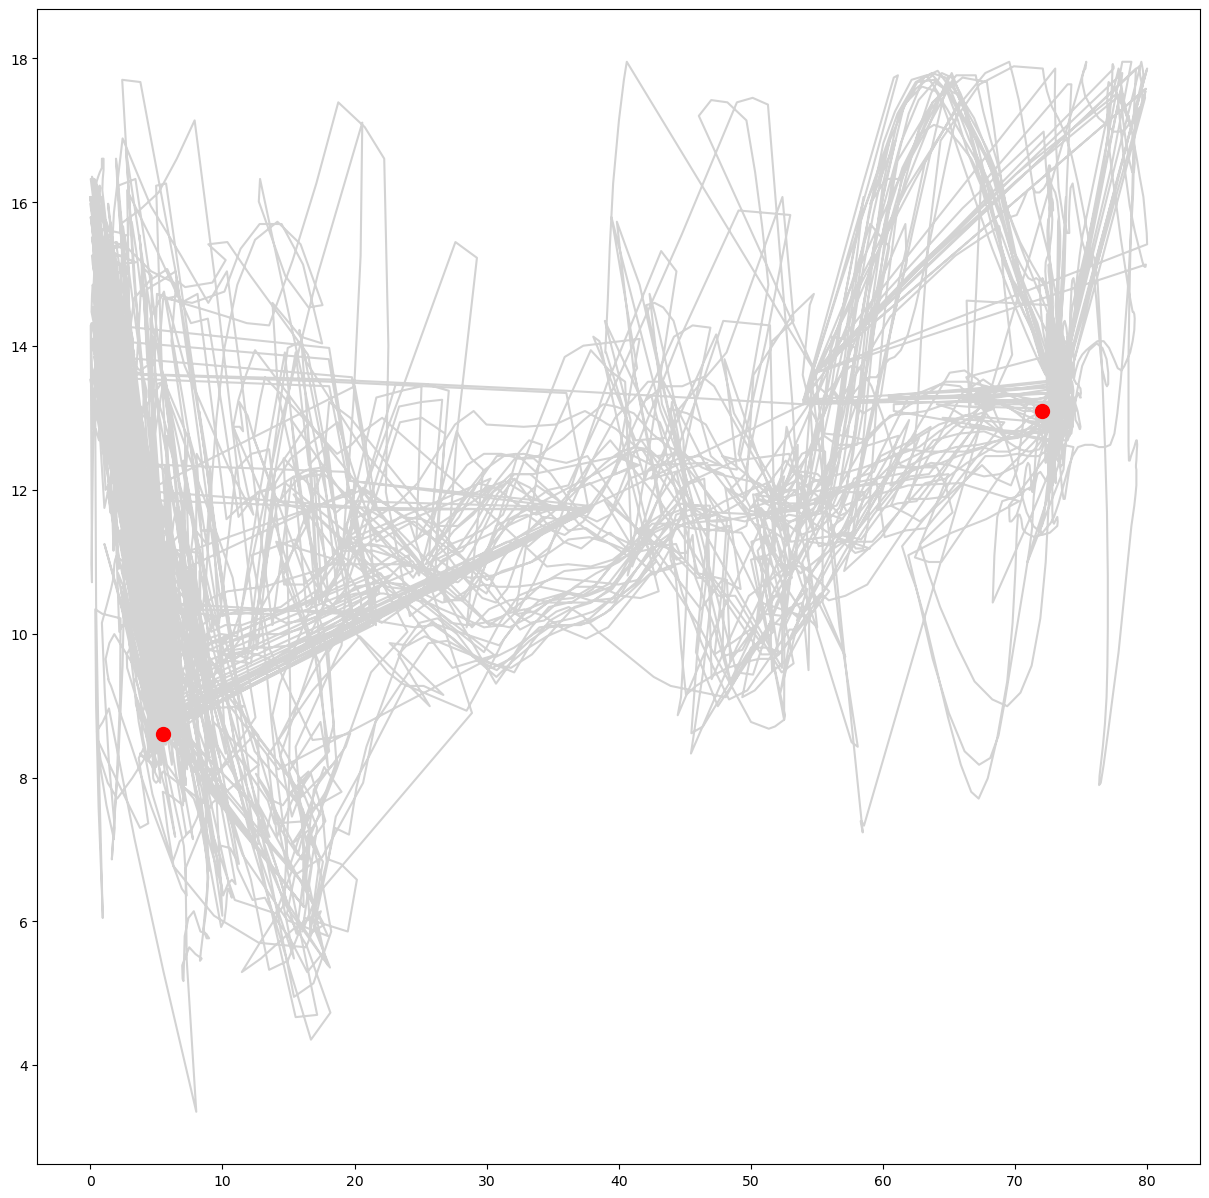

In [31]:
nwb_file_name = "Frodo20230809_.nwb"
pos_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": "pos 1 valid times",
    "position_info_param_name": "default",
    "trodes_pos_params_name": "single_led"
}
position_info = (sgp.TrodesPosV1() & pos_key).fetch1_dataframe()


fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.plot(
    position_info.position_x,
    position_info.position_y,
    color="lightgrey",
    zorder=-1
)


node_positions = np.array([
    (5.5, 8.6),
    (72,13.1)
])
edges = np.array([
    (0,1)
])
linear_edge_order = [(0,1)]
linear_edge_spacing=15
sgpl.TrackGraph.insert1(
    {
        "track_graph_name": "ms_lineartrack_2023",
        "environment": "lineartrack",
        "node_positions": node_positions,
        "edges": edges,
        "linear_edge_order": linear_edge_order,
        "linear_edge_spacing": linear_edge_spacing,
    },
    skip_duplicates=True,
)
plt.scatter(node_positions[:,0],node_positions[:,1],color='red',s=100)                        

Frodo20230809_.nwb


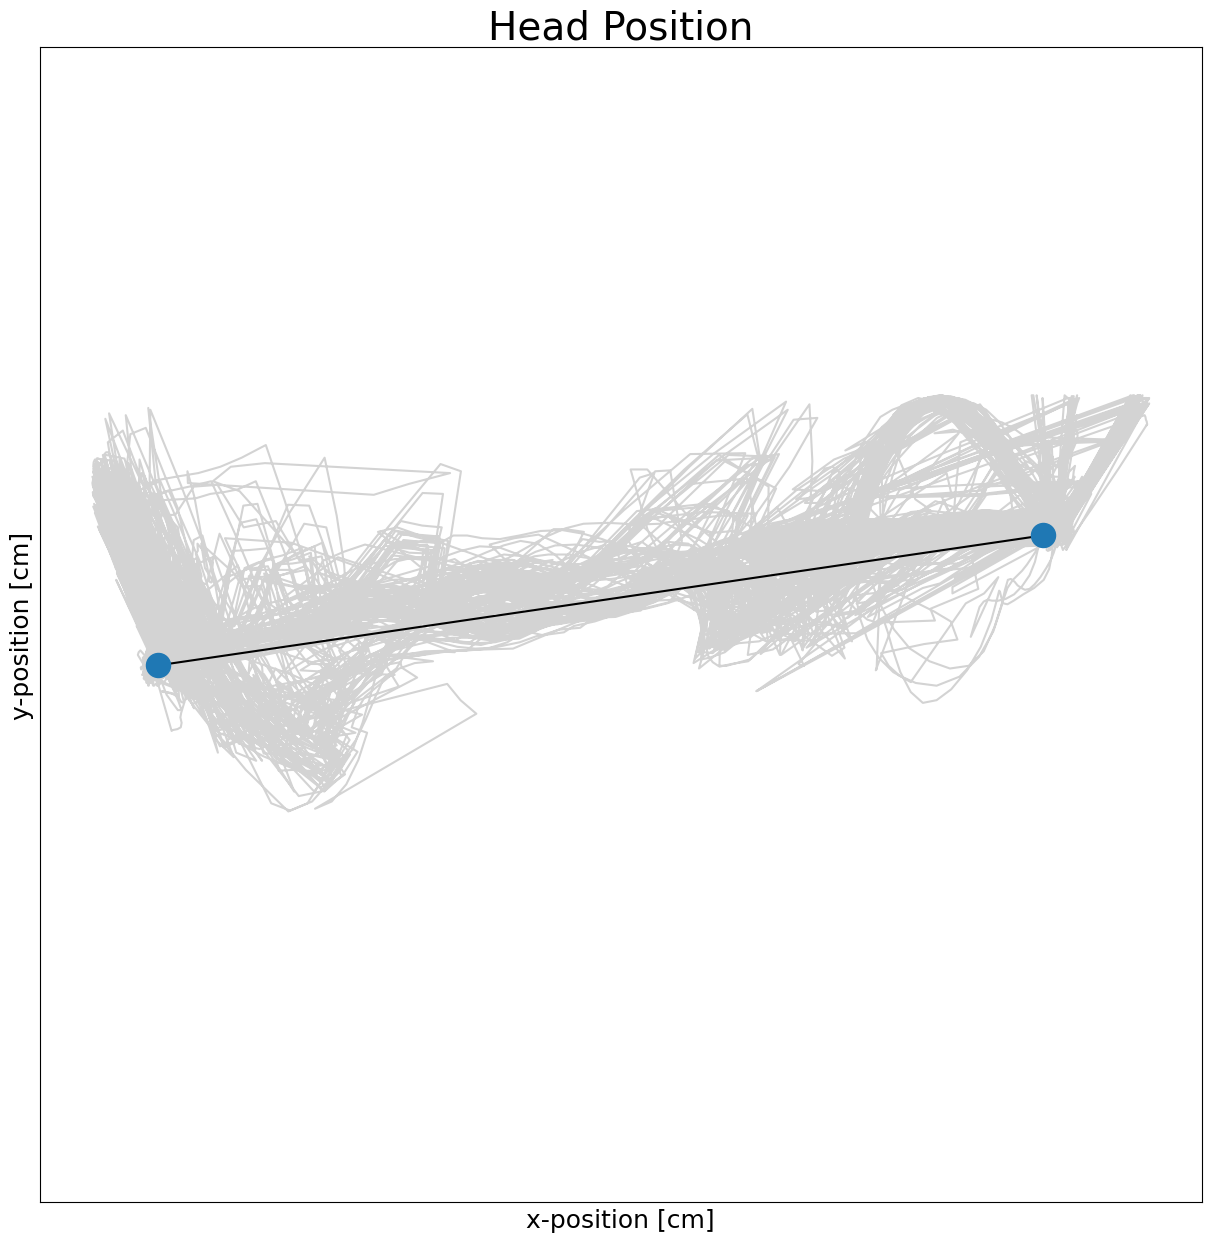

In [33]:


nwb_file_name = "Winnie20220713_.nwb"
# nwb_file_name = 'Banner20211231_.nwb'
# nwb_file_name = "Yoshi20220513_.nwb"
nwb_file_name = "Frodo20230809_.nwb"
# nwb_file_name = "Bilbo20230725_.nwb"

# animal = (sgc.Session() & {"nwb_file_name": nwb_file_name}).fetch1("subject_id")
# animal = 'Winnie'
track_graph_name = f'ms_lineartrack'

if 'Frodo' in nwb_file_name or 'Bilbo' in nwb_file_name:
    track_graph_name = 'ms_lineartrack_2023'

# define keys
pos_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": "pos 3 valid times",
    "position_info_param_name": "default",
    "trodes_pos_params_name": "single_led"
}

track_key = {
    "track_graph_name": track_graph_name,
}



# get position info
merge_id = (PositionOutput.TrodesPosV1() & pos_key).fetch1("merge_id")
# position_info = (PositionOutput() & {"merge_id": merge_id}).fetch1_dataframe()#(restriction=pos_key)
position_info = (sgp.TrodesPosV1() & pos_key).fetch1_dataframe()
#plot position info
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.plot(
    position_info.position_x,
    position_info.position_y,
    color="lightgrey",
    zorder=-1
)
ax.set_xlabel("x-position [cm]", fontsize=18)
ax.set_ylabel("y-position [cm]", fontsize=18)
ax.set_title("Head Position", fontsize=28)
plt.ylim(-10,30)

if sgpl.TrackGraph() & track_key:
    graph = (sgpl.TrackGraph() & track_key)
    graph.plot_track_graph(ax=ax)
    
else:
    print("No track graph found")
    print("Please define a graph in the cell below and re-run this cell")
print(nwb_file_name)

In [27]:
table = (PositionOutput() & {'merge_id':merge_id})
# table.fetch1_dataframe()#).fetch1_dataframe()
key = table.merge_restrict(table.proj())
table.merge_get_parent(table.proj())
key
# query = (
#             source_class_dict[
#                 to_camel_case(table.merge_get_parent(table.proj()).table_name)
#             ]
#             & key
#         )

to_camel_case(table.merge_get_parent(table.proj()).table_name)

NameError: name 'to_camel_case' is not defined

In [25]:
track_key = (sgpl.TrackGraph() & track_key).fetch(as_dict=True)[0]
track_key['track_graph_name'] = "ms_lineartrack"
sgpl.TrackGraph().insert1(track_key)

## Cleanup Previously populated entries

In [58]:
# from spyglass.utils.dj_merge_tables import delete_downstream_merge
# animal_pos_merge_id = (PositionOutput().TrodesPosV1() & "nwb_file_name LIKE 'Bilbo%'").proj(pos_merge_id = 'merge_id').fetch('pos_merge_id', as_dict=True)
# (sgpl. LinearizationSelection() & animal_pos_merge_id)#.delete(animal_pos_merge_id)
# delete_downstream_merge(sgpl.LinearizationSelection, animal_pos_merge_id,dry_run=0)
# (sgpl. LinearizationSelection() & animal_pos_merge_id).delete(animal_pos_merge_id)
# # sgpl.LinearizationSelection()# & "nwb_file_name LIKE 'Frodo%'"

## Populate the Selection keys

In [2]:
PositionOutput.TrodesPosV1()

merge_id,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters
0a5ddae3-31cd-f0de-d3c2-47ed53d7f908,Banner20211221_.nwb,pos 0 valid times,single_led
c643ef42-63e5-0ab7-5fc9-46f9ecf50b11,Banner20211221_.nwb,pos 0 valid times,single_led_upsampled
0f37ed35-616e-2bba-ff50-5b1518679d45,Banner20211221_.nwb,pos 1 valid times,single_led
c775981e-4f93-e7fc-7d48-cc0800460301,Banner20211221_.nwb,pos 1 valid times,single_led_upsampled
a703e1de-b161-a6e1-1cac-11f63634f484,Banner20211222_.nwb,pos 0 valid times,single_led
bf64a250-e4a6-0e73-9519-80d3b8358a52,Banner20211222_.nwb,pos 0 valid times,single_led_upsampled
67f1d997-cc7b-3767-ef2f-74f1a4186f4b,Banner20211222_.nwb,pos 1 valid times,single_led
9a4580d5-3eca-1cc8-81cf-2c51e837e483,Banner20211222_.nwb,pos 1 valid times,single_led_upsampled
6a6337ca-9f93-07ff-b13c-19bbb69af046,Banner20211222_.nwb,pos 2 valid times,single_led
551f68cf-9f81-c6a5-f6d3-4325b5948f50,Banner20211222_.nwb,pos 2 valid times,single_led_upsampled


In [59]:
# track_graph_name = f'ms_lineartrack'
trodes_pos_params_name = 'single_led_upsampled'
for animal in ['Winnie','Wallie','Yoshi','Frodo','Banner', 'Odins','Dan',
               'Totoro','Olive','Bilbo']:
    merge_id_list = (PositionOutput.TrodesPosV1() & f"nwb_file_name LIKE '{animal}%'"
                     & {'trodes_pos_params_name':trodes_pos_params_name}).fetch('merge_id')
    for merge_id in merge_id_list:
        if animal in ["Bilbo", "Frodo"]:
            track_graph_name = 'ms_lineartrack_2023'
        else:
            track_graph_name = 'ms_lineartrack'
        sgpl.LinearizationSelection.insert1(
            {
                "pos_merge_id": merge_id,
                "track_graph_name": track_graph_name,
                "linearization_param_name": "default",
            },
            skip_duplicates=True,
        )

sgpl.LinearizationSelection()

pos_merge_id,track_graph_name,linearization_param_name name for this set of parameters
af2e637c-47d9-8e27-11f1-3ac12431f417,6 arm,default
001b5af0-489e-5437-9e34-f2130727ebc5,ms_lineartrack,default
002476a5-c344-0236-d86c-89b995e22227,ms_lineartrack,default
00551a35-a28e-c884-0c33-8f3817cf59c2,ms_lineartrack,default
006bfebf-d986-e309-06ed-d7ea7c871c46,ms_lineartrack,default
00a9088c-6746-7892-d2ca-2e86e9047a60,ms_lineartrack,default
00afca31-a7b3-7d44-4752-531de37263a3,ms_lineartrack,default
00c9698e-146e-3bdc-61e4-c19ad4c8840d,ms_lineartrack,default
00eaf8e9-168b-9c46-1621-e11b3bee558d,ms_lineartrack,default
01717e02-3d2c-14ad-0a74-d1bd7f8417f0,ms_lineartrack,default


In [62]:
sgpl.LinearizationSelection() & {"track_graph_name":"ms_lineartrack_2023"}

pos_merge_id,track_graph_name,linearization_param_name name for this set of parameters
02dea84b-9d73-d726-63c4-86db800248c4,ms_lineartrack_2023,default
031d045c-70b3-be30-4e4d-0e52aa9ab2cb,ms_lineartrack_2023,default
04e437a3-68f2-4648-80ce-366f2b88bd99,ms_lineartrack_2023,default
069daba8-e2c8-456a-f13e-efa54bfcea89,ms_lineartrack_2023,default
072ab650-5703-79bc-b92e-14424a1e04aa,ms_lineartrack_2023,default
0b3d2de0-c325-6656-4647-bbbb0298a4c3,ms_lineartrack_2023,default
0b4a2973-e625-6f32-55cf-20a55479eed9,ms_lineartrack_2023,default
0bb387ba-63f5-e474-2950-0bbc09d7c2d7,ms_lineartrack_2023,default
0c54ddf6-c760-0557-45e0-14dc95ad1188,ms_lineartrack_2023,default
0f63f488-5fff-084f-141a-b455408cc193,ms_lineartrack_2023,default


## Populate the LinearizationV1 table

In [63]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
sgpl.LinearizedPositionV1().populate(processes=16)

[13:38:34][INFO] Spyglass: Computing linear position for: {'pos_merge_id': UUID('072ab650-5703-79bc-b92e-14424a1e04aa'), 'track_graph_name': 'ms_lineartrack_2023', 'linearization_param_name': 'default'}
[13:38:34][INFO] Spyglass: Computing linear position for: {'pos_merge_id': UUID('031d045c-70b3-be30-4e4d-0e52aa9ab2cb'), 'track_graph_name': 'ms_lineartrack_2023', 'linearization_param_name': 'default'}
[13:38:34][INFO] Spyglass: Computing linear position for: {'pos_merge_id': UUID('069daba8-e2c8-456a-f13e-efa54bfcea89'), 'track_graph_name': 'ms_lineartrack_2023', 'linearization_param_name': 'default'}
[13:38:34][INFO] Spyglass: Computing linear position for: {'pos_merge_id': UUID('0b3d2de0-c325-6656-4647-bbbb0298a4c3'), 'track_graph_name': 'ms_lineartrack_2023', 'linearization_param_name': 'default'}
[13:38:34][INFO] Spyglass: Computing linear position for: {'pos_merge_id': UUID('11ade70f-ddd8-221f-046a-b657b55bcc44'), 'track_graph_name': 'ms_lineartrack_2023', 'linearization_param_nam

In [36]:
sgpl.LinearizedPositionV1()

pos_merge_id,track_graph_name,linearization_param_name name for this set of parameters,analysis_file_name name of the file,linearized_position_object_id
001b5af0-489e-5437-9e34-f2130727ebc5,ms_lineartrack,default,Winnie20220714_8FOZKCPEXW.nwb,9b7b03d8-1df8-4a04-9566-ada9ad7d935e
00551a35-a28e-c884-0c33-8f3817cf59c2,ms_lineartrack,default,Olive20220707_FIDPJQ458I.nwb,71ab61e9-cf9b-436c-b489-9f09b6f989da
00afca31-a7b3-7d44-4752-531de37263a3,ms_lineartrack,default,Wallie20220922_EP1QE0SBJR.nwb,b2797c39-606f-43cb-8d8f-652870b9db67
00c9698e-146e-3bdc-61e4-c19ad4c8840d,ms_lineartrack,default,Olive20220708_XXXT7RYLRX.nwb,8bbd3fb5-6cab-491a-8d74-c06818678248
022c034d-da79-ca8c-a758-6c2e78b65fcf,ms_lineartrack,default,Winnie20220720_F3YE2F28QX.nwb,2fc84409-b55f-44b0-9d72-740fdf5269c4
02e45fe1-a55d-124a-18b2-88ea2a811ee1,ms_lineartrack,default,Yoshi20220513_P0CS8SDDGH.nwb,129f54bc-f0f0-4136-af48-7e20923656f7
034625b0-b78d-5dba-3c14-1ac04ee20f0e,ms_lineartrack,default,Frodo20230814_D1UOVKS0P2.nwb,eb948bb1-c216-478c-9e8b-858c0a635fbc
0355560d-43fa-0200-88d3-708b7f425ef7,ms_lineartrack,default,Winnie20220716_P9SJOB4S8U.nwb,0cfda902-8b81-4eed-9604-087f6b4eaa27
035b1148-b4c9-7c1b-36a0-4ccdd4d280fa,ms_lineartrack,default,Frodo20230810_KUUGULBI4M.nwb,3fcca6ed-304f-437c-a786-7dc029bedccd
03eb609d-75bb-1122-74a2-70cda8e12cdd,ms_lineartrack,default,Frodo20230816_9DQBEDMT7P.nwb,743693b1-d077-4667-a81f-27b7de61db01


,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.657320e+09,65.975688,0,79.738390,90.490655
1.657320e+09,65.975688,0,79.738390,90.490655
1.657320e+09,65.975688,0,79.738390,90.490655
1.657320e+09,65.975688,0,79.738390,90.490655
1.657320e+09,65.975688,0,79.738390,90.490655
...,...,...,...,...
1.657321e+09,67.561196,0,81.318196,90.625008
1.657321e+09,67.561196,0,81.318196,90.625008
1.657321e+09,67.561196,0,81.318196,90.625008


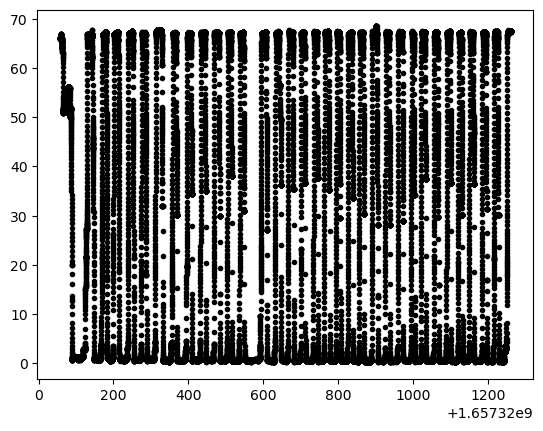

In [49]:

merge_id = '04442dc4-f68c-de4e-056b-596e388d9312'
merge_id = '00c9698e-146e-3bdc-61e4-c19ad4c8840d'
df = (sgpl.LinearizedPositionV1() & {'pos_merge_id': merge_id}).fetch1_dataframe()

plt.plot(df.index,df.linear_position, 'k.')
df

In [60]:
track_graph = (sgpl.TrackGraph() & {'track_graph_name':'ms_lineartrack'}).get_networkx_track_graph()
edge_order = np.asarray(track_graph.edges)
track_graph.edges[[0,1]]["distance"]

# edge_order

68.4461832390967

In [4]:
sgpl.LinearizedPositionV1() & {'analysis_file_name LIKE "Bilbo%"'}

pos_merge_id,track_graph_name,linearization_param_name name for this set of parameters,analysis_file_name name of the file,linearized_position_object_id
